# Nested K-fold

## Carrega os dados

In [9]:
!pip install pandas numpy matplotlib seaborn scikit-learn Jinja2

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

data = np.genfromtxt("californiabin.csv", delimiter=',')
x = data[:,:-1]
y = data[:,-1].astype(int)

x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Número de amostras: {x.shape[0]}")
print(f"Número de dimensões: {x.shape[1]}")
print(f"Amostras por classe: {np.unique(y, return_counts=True)}")

Número de amostras: 1600
Número de dimensões: 8
Amostras por classe: (array([0, 1]), array([814, 786]))


## Funções principais

In [59]:
def inner_loop(x, y, model_class, grid, internal_kfold=10, scale_flag=True, verbose=True, random_state=12345):
    param_names = list(grid.keys())
    grid_search = np.meshgrid(*grid.values())
    grid_search = np.hstack([ np.atleast_2d(g.ravel()).T for g in grid_search ], dtype='object')
    
    for i, params in enumerate(grid_search):
        param_dict = dict(zip(param_names, params))

        if verbose:
            print(f"Testing parameters: {param_dict}")
        
        kf = KFold(n_splits=internal_kfold, shuffle=True, random_state=random_state)
        fold_scores = []
        
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if scale_flag:
                model = make_pipeline(StandardScaler(), model_class(**param_dict))
            else:
                model = model_class(**param_dict)
            
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            fold_scores.append(accuracy_score(y_test, y_pred))
        
        yield param_dict, fold_scores
    

In [60]:
def run_nested_cv(x, y, model_class, grid, external_kfold=5, internal_kfold=5, scale_flag=True, verbose=True, random_state=12345):
    metrics = {'acc': [], 'rec': [], 'prec': [], 'f1': []}

    Kf = KFold(n_splits=external_kfold, shuffle=True, random_state=random_state)

    best_model = None
    best_score = -np.inf
    
    for train_index, test_index in Kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for params, fold_scores in inner_loop(x_train, y_train, model_class, grid, internal_kfold, scale_flag, verbose, random_state):
            mean_score = np.mean(fold_scores)
            std_score = np.std(fold_scores)
            if verbose:
                print(f"Mean accuracy for parameters {params}: {mean_score:.4f}")
                print(f"Standard deviation: {std_score:.4f}")

            if mean_score > best_score:
                best_score = mean_score
                best_model = make_pipeline(StandardScaler(), model_class(**params)) if scale_flag else model_class(**params)
                best_model.fit(x_train, y_train)

        y_pred = best_model.predict(x_test)
        metrics['acc'].append(accuracy_score(y_test, y_pred))
        metrics['rec'].append(recall_score(y_test, y_pred, average='macro'))
        metrics['prec'].append(precision_score(y_test, y_pred, average='macro'))
        metrics['f1'].append(f1_score(y_test, y_pred, average='macro'))

                           
    return metrics, best_model

## Executa o grid-search para os modelos

In [62]:
external_kfold = 5
internal_kfold = 10

methods_summary = {'SVM' : {'class': SVC, 'scale': True},
                   'RF': {'class': RandomForestClassifier, 'scale': False},
                   }


# Support vector machine
methods_summary['SVM']['grid'] = {'C': [2 ** -5, 2 ** -3, 2 ** -1, 2 ** 1, 2 ** 3, 2 ** 5, 2 ** 7, 2 ** 9, 2 ** 11, 2 ** 13, 2 ** 15],
                                  'gamma': [2 ** -15, 2 ** -13, 2 ** -11, 2 ** -9, 2 ** -7, 2 ** -5, 2 ** -3, 2 ** -1, 2 ** 1, 2 ** 2, 2 ** 3],
                                  'kernel': ['rbf'],
                                  'probability': True
                                }

# Random Forest
methods_summary['RF']['grid'] = {'n_estimators': [10, 20, 30, 40, 50, 60, 
                                                  70, 80, 90, 100, 110, 
                                                  120, 130, 140, 150, 160,
                                                  170, 180, 190, 200],  
                                 'max_depth': [None, 4, 6, 8, 10]    
                                }

trained_models = {}
for method, info in methods_summary.items():
    print(f"\n[{method}] Running nested K-fold...")
    metrics, best_model = run_nested_cv(x=x, y=y, model_class=info['class'],
                                        grid=info['grid'], scale_flag=info['scale'],
                                        external_kfold=external_kfold, internal_kfold=internal_kfold, verbose=False, random_state=42)
    trained_models[method] = {'metrics': metrics, 'model': best_model}


# Results
results = { method : info['metrics'] for method, info in trained_models.items() }


[SVM] Running nested K-fold...

[RF] Running nested K-fold...


## Tabela de resultados do Nested K-fold

In [63]:
table = pd.DataFrame(results).T.map(lambda x: f"{np.mean(x):.2%} +- {1.96*np.std(x)/np.sqrt(len(x)):.2%}")
table.columns = ['Accuracy', 'Recall', 'Precision', 'F1-score']
table.index = results.keys()
def extract_from_text(text):
    return float(text.split('%')[0])
table.style.apply(lambda col: [ 'font-weight:bold; color:red' if extract_from_text(x)==col.apply(extract_from_text).max() else '' for x in col ])

,Accuracy,Recall,Precision,F1-score
SVM,85.94% +- 1.10%,85.97% +- 1.08%,85.98% +- 1.09%,85.92% +- 1.10%
RF,92.44% +- 5.53%,92.43% +- 5.54%,92.42% +- 5.54%,92.42% +- 5.54%


## Curvas ROC/PRC e matriz de confusão no conjunto de teste separado

In [68]:
def calculate_auc_metrics(model, x_test, y_test):
        # Obter probabilidades ou decisões do modelo
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(x_test)[:, 1]
        else:
            y_scores = model.decision_function(x_test)
        
        # Calcular AUROC
        auroc = roc_auc_score(y_test, y_scores)
        
        # Calcular AUPRC
        auprc = average_precision_score(y_test, y_scores)
        
        
        print(f"AUROC: {auroc}\n")
        print(f"AUPRC: {auprc}\n")

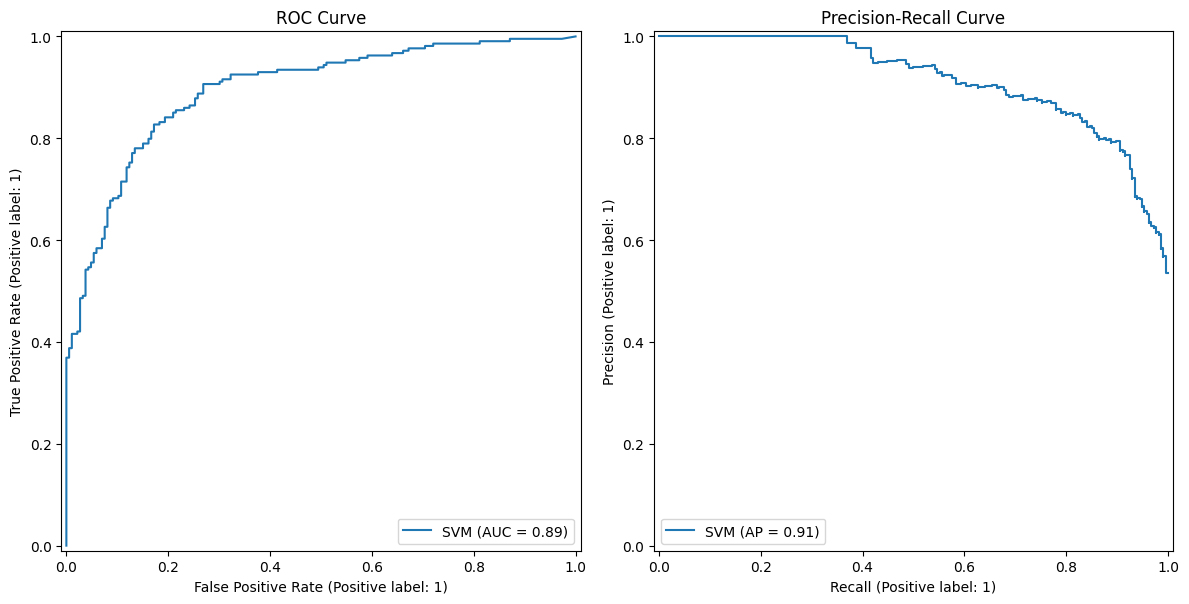

AUROC: 0.9420189620571299

AUPRC: 0.9401680017945182



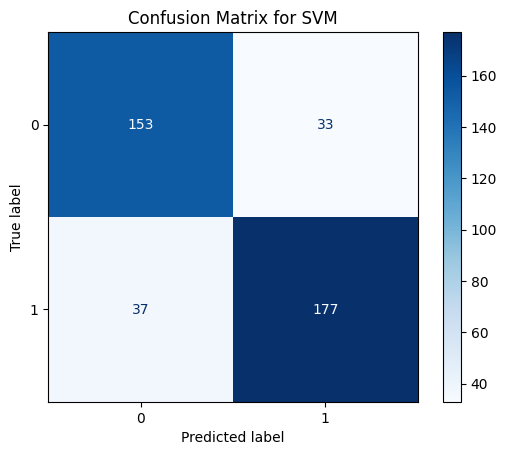

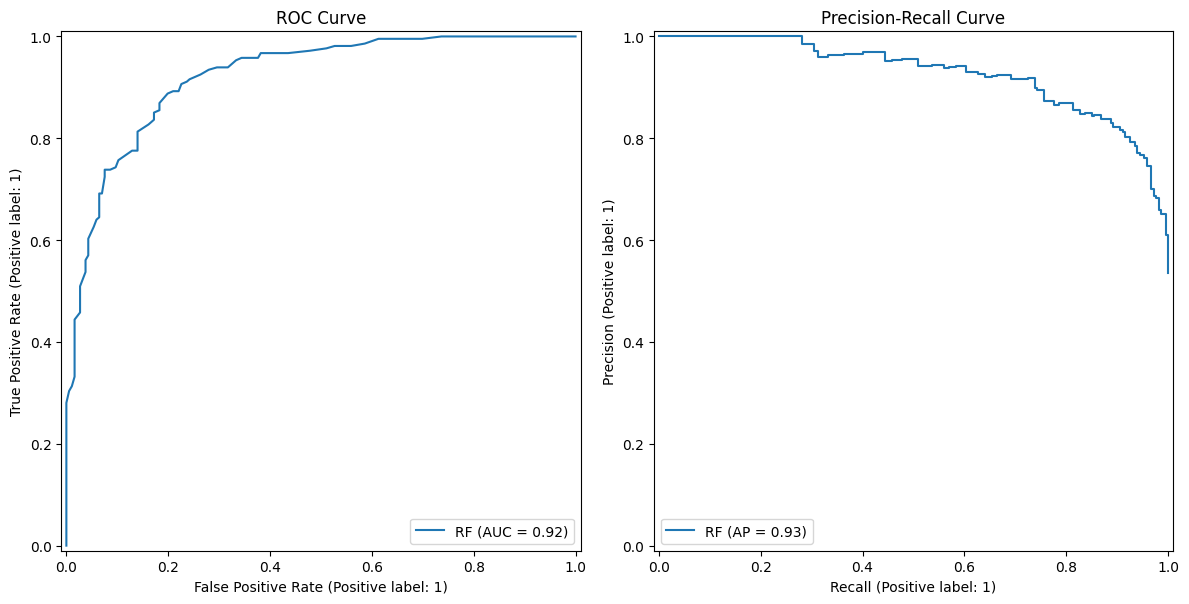

AUROC: 1.0

AUPRC: 0.9999999999999999



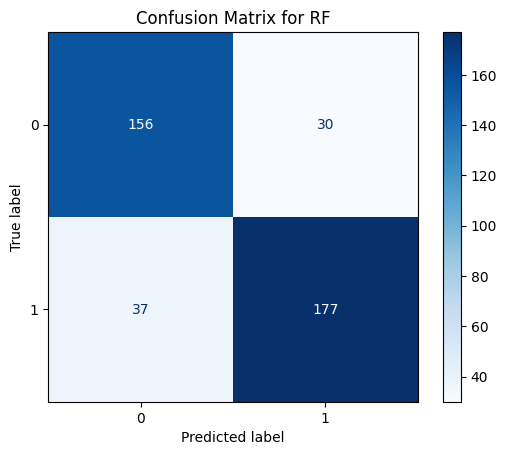

In [69]:
for model_name, model_data in trained_models.items():

    
    # Construir o pipeline apropriado
    if model_name == "SVM":
        model = make_pipeline(
            StandardScaler(),
            model_data['model']  # Usar metrics em vez de metrics
        )
    else:
        model = make_pipeline(
            model_data['model']
        )
    
    # Treinar o modelo
    model.fit(x, y)
    
    # Fazer previsões
    y_pred = model.predict(x_test)
    
    y_pred_proba = model.predict_proba(x_test)
        
    # Plotting ROC and Precision-Recall curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1], ax=axes[0], name=model_name)
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:, 1], ax=axes[1], name=model_name)
    axes[0].set_title('ROC Curve')
    axes[1].set_title('Precision-Recall Curve')
    plt.tight_layout()
    plt.show()

    
    calculate_auc_metrics(model,x,y)
        
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(y), cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()